# E6 — Combining ion current models in the action potential 

In this notebook we will explore how the major cardiac currents contribute to differences in the atrial and ventricular action potentials and hoping to achieve some intuitive understanding of what the defining currents are in each of these tissues. 

First we need to get a little more familiar with what one of these models looks like. The process for constructing an action potential model from the many ion channels, tranporters, and buffer models that make a cell, is an extension of what you have already learned from the earlier exercises.

You need:
1. Your system of equations (from which you formulate the RHS)
2. An initial condition (starting values for each variable in the RHS)
3. The collection of parameters (generally constants) necessary to calculate the RHS 
4. A time vector over which to integrate the system

## Exercise 1: the Hodgkin-Huxley model

We'll look first at the Hodgkin-Huxley model from earlier. It has an activation gated ($n$) ${\rm K}^+$  current, a ${\rm Na}^+$ current with both activation ($m$) and inactivation ($h$) gates, a small nondescript leak current ($I_{\rm L}$) to maintain resting potential, and it accepts a stimulus current $I_{\rm app}$:
$$C_{\rm m}\frac{{\rm d}V}{{\rm d}t} = -(g_{\rm Na} m^3h(V-E_{\rm Na}) + g_{\rm K} n^4(V-E_{\rm K}) + g_{\rm L}(V-E_{\rm L}) + I_{\rm app})$$

where $m$ is controlled by:
$$ \frac{{\rm d}m}{{\rm d}t} = \alpha_m (1-m)-\beta_m m$$

$h$ is controlled by:
$$ \frac{{\rm d}h}{{\rm d}t} = \alpha_h (1-h)-\beta_h h$$

and $n$ is controlled by:
$$ \frac{{\rm d}n}{{\rm d}t} = \alpha_n (1-n)-\beta_n n$$

First some tools and then we start with the right hand side:

In [6]:
# Import necessary packages
import numpy as np
from math import exp 
import matplotlib.pylab as plt
%matplotlib inline
from scipy.integrate import odeint

In [7]:
#Parameters
p = {}
p['Cm'] = 1.0 # uF/cm^2
p['E_Na'] = 50 # mV
p['E_K'] = -80 # mV
p['E_L'] = -75 # mV
p['gNa'] = 120 # mS/cm^2
p['gK'] = 40 # mS/cm^2
p['gL'] = 0.3 # mS/cm^2
p['I_app'] = 100 # uA/cm^2

In [8]:
def rhs(y,t,p):
    
    # unpack the solution vector
    m, h, n, V = y 
    
    # unpack the passed parameters
    Cm = p['Cm']
    E_Na = p['E_Na']
    E_K = p['E_K']
    E_L = p['E_L']
    gNa = p['gNa']
    gK = p['gK']
    gL = p['gL']
    I_app = p['I_app']
    
    # calculate the transition rates
    alpha_m = 0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0))
    beta_m  = 4.0*np.exp(-(V+65.0)/18.0)
    alpha_h = 0.07*np.exp(-(V+65.0)/20.0)
    beta_h  = 1.0/(1.0+np.exp(-(V+35.0)/10.0))
    alpha_n = 0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0))
    beta_n  = 0.125*np.exp(-(V+65)/80.0)

    # calculate the currents
    I_app = -I_app if 2<t<4 else 0.0
    I_Na = gNa*m**3*h*(V - E_Na)
    I_K = gK*n**4*(V - E_K)
    I_L = gL*(V - E_L)
    
    # calculate the derivatives
    dm_dt = alpha_m*(1-m) - beta_m*(m)
    dh_dt = alpha_h*(1-h) - beta_h*(h)
    dn_dt = alpha_n*(1-n) - beta_n*(n)
    dV_dt = -(I_Na + I_app + I_K)/Cm
    
    # assemble and return dy/dt
    return[dm_dt,dh_dt,dn_dt,dV_dt]

In [9]:
#Initial conditions   
m0 = 0
h0 = 1
n0 = 0
V0 = -80
y0 = [m0,h0,n0,V0]

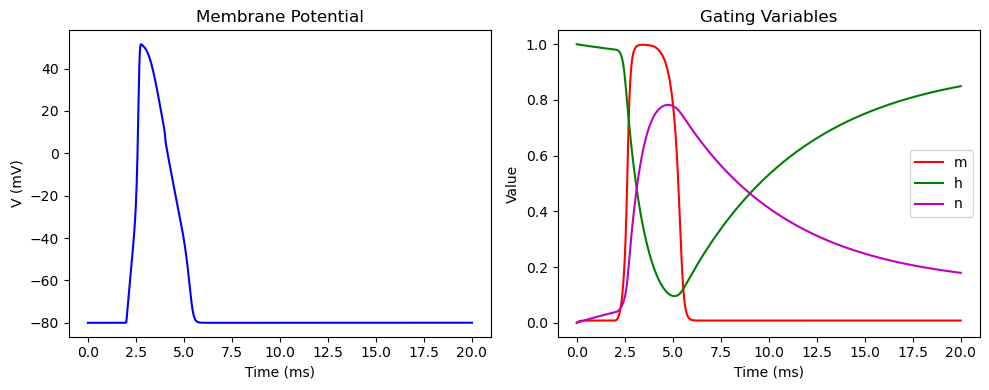

In [11]:
# Run the model
# Your code here:

# The time vector
time = np.linspace(0,20,1000)

# Solve the model
y = odeint(rhs,y0,time,(p,))

# Unpack the solution 
m = y[:,0]
h = y[:,1]
n = y[:,2]
V = y[:,3]

# Plot the solution
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Membrane potential over time
axs[0].plot(time, V, 'b')
axs[0].set_title('Membrane Potential')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('V (mV)')

# Subplot 2: Gating variables over time
axs[1].plot(time, m, 'r', label='m')
axs[1].plot(time, h, 'g', label='h')
axs[1].plot(time, n, 'm', label='n')
axs[1].set_title('Gating Variables')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Value')
axs[1].legend()

# Layout adjustment
plt.tight_layout()
plt.show()

## Exercise 2: A more complex model...

Next we'll work with a human ventricular myocyte model. This is one of several human-specific ventricular myocyte models, and was developed by Eleonora Grandi at UC Davis. The code we will run is slightly simplified from the published version, but still quite complex. It is generally difficult to interpret any new model, but getting used to looking for the necessary elements is the best way to start. Let's take a look:

* [Grandi-Bers Ventricular RHS](GBV_RHS.py)
* [Grandi-Bers Ventricular Initialization](GBV_D.py)
* [Grandi-Bers Ventricular Run](GBV_run.py)


Our objective with this section is to develop some familiarity with how these cell models are structured, and some intuition for how the major currents in the ventricle and atria determine the integrated electrophysiology of the cell. Unfortunately we won't have a chance to look at complex effects, such as frequency-dependent outcomes, but we can at least gain a sense of how each current contributes to changes in action potential morphology.  

First, some more tools.

In [12]:
from ipywidgets import interact, FloatSlider, Dropdown
import L6_widgets as L6
import importlib

Now we'll load a widget that will let you inspect the behaviour of the ventricular AP model by changing the conductances of all the major sarcolemmal currents. 

*FIRST*: Answer some intuitive questions that you should already have a good idea about:

1. What is the maximum reachable positive potential?
2. Which current maintains a stable resting potential?
3. Is it possible to make the human AP as short as a mouse AP (~30 ms)? How?
4. Is it possible to prolong the AP by increasing a potassium channel conductance?
5. Is it possible to increase the peak of the calcium transient by increasing a potassium channel conductance?
6. How do $I_{NCX}$ and $I_{NKa}$ modulate repolarisation?
7. What are the background currents (NaB, ClB, CaB)? Are they important?

**See if the model agrees...**

In [13]:
importlib.reload(L6)
L6.VentricularAPWidget()

interactive(children=(Dropdown(description='Cell type:', options={'Epi': 1, 'Endo': 0}, value=1), FloatSlider(…

## Exercise 3: Reachable model configurations

Because of the uncertainty in model construction, and variability in the underlying experimental data, it is always tempting to ask what are the major differences between models thought to represent different biological contexts. The next widget asks you to try to turn a ventricular cell into an atrial cell. We have made it somewhat easier by using an atrial model from the same authors. See how close you can get.

In [14]:
importlib.reload(L6)
L6.VentricularAPWidget2()

interactive(children=(Dropdown(description='Cell type:', options={'Epi': 1, 'Endo': 0}, value=1), FloatSlider(…

### What about in the other direction?

Is it possible to make the atrial model look like a ventricular cell?

In [15]:
importlib.reload(L6)
L6.AtrialAPWidget()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='gNa scale factor', max=10.0…